In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sdrudp.resample import resample

We inject a tone with known frequency $\nu$. If the sampling rate of the ADC $f_s^{\rm ADC}$ differs from the desired (master) sampling rate $f_s$, there will be a phase difference:

$$V(t) = e^{i2\pi\nu t},\, V_{\rm ADC}(t) = e^{i2\pi\nu t_{\rm ADC}} \\
e^{i \Delta \phi} = V_{\rm ADC}V^* = e^{i2\pi\nu (t_{\rm ADC}-t)} \\
\Delta \phi = 2\pi\nu (t_{\rm ADC}-t) = 2\pi\nu t \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right)$$

If there's also some phase difference $\phi_0$ at $t=0$, we get:
$$\Delta \phi = 2\pi\nu t \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right) + \phi_0$$

Thus, if we measure the phase difference, we can recover the sampling rate of the ADC:
$$\frac{f_s}{f_s^{\rm ADC}} - 1 = \frac{\Delta \phi-\phi_0}{2\pi\nu t} \\
f_s^{\rm ADC} = f_s \frac{2\pi\nu t}{\Delta \phi-\phi_0 + 2\pi\nu t}$$

Note that $\Delta \phi$ by defintion is between $-\pi$ and $\pi$, so we need to unwrap $\Delta \phi$ (i.e., add multiples of $2\pi$ using ``np.unwrap``) before applying the formula above.

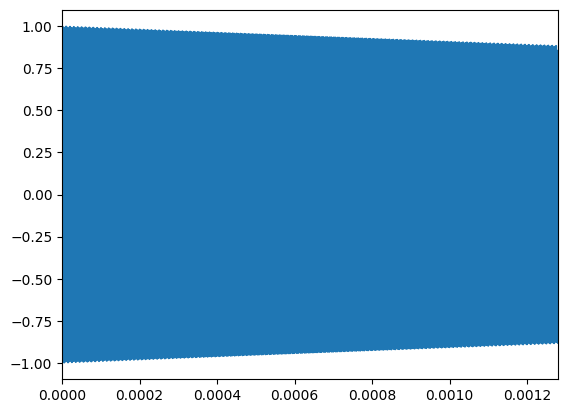

In [129]:
NSAMPLES = 4096
TONE = 901.5e6
LO = 901e6
SAMPLE_RATE = 3.2e6
t = np.arange(NSAMPLES) / SAMPLE_RATE
omega = 2 * np.pi * (TONE - LO)
tone_cos = np.cos(omega * t)
tone_sin = -np.sin(omega * t)  # conjugate

sample_fq = 3.200105e6
OFFSET = np.pi/3
re = np.cos(omega * t * SAMPLE_RATE / sample_fq + OFFSET)
im = np.sin(omega * t * SAMPLE_RATE / sample_fq + OFFSET)
data = np.array([re, im]).T
data = np.expand_dims(data, axis=0)  # add block axis (with nblocks=1)

plt.figure()
plt.plot(t, tone_cos-re)
plt.xlim(t.min(), t.max())
plt.show()

In [130]:
data = data - np.mean(data, axis=1, keepdims=True)  # remove DC offset
real = data[0, :, 0]
imag = data[0, :, 1]
data_cos = real * tone_cos - imag * tone_sin  # real part (real*real - im*im)
data_sin = real * tone_sin + imag * tone_cos  # imaginary (real*im + im*real)
dphi = -np.arctan2(data_sin, data_cos) # phase difference in units of radians
dphi -= dphi[0]

# recover the ADC sample rate
den = omega * t - np.unwrap(dphi)
nonzero = den != 0
sample_ADC = np.mean(SAMPLE_RATE * omega * t[nonzero] / den[nonzero])
print(sample_ADC / sample_fq)  # how close we are to the true ADC sampling rate

0.9999999681248691


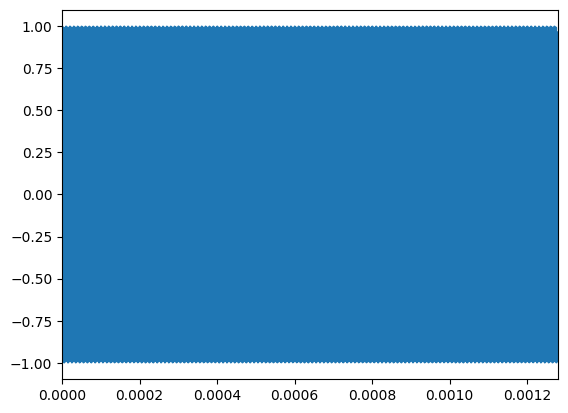

In [131]:
resamp_real = resample(real, sample_ADC, SAMPLE_RATE)
resamp_imag = resample(imag, sample_ADC, SAMPLE_RATE)

plt.figure()
plt.plot(t, tone_cos - resamp_real)
plt.xlim(t.min(), t.max())
plt.show()

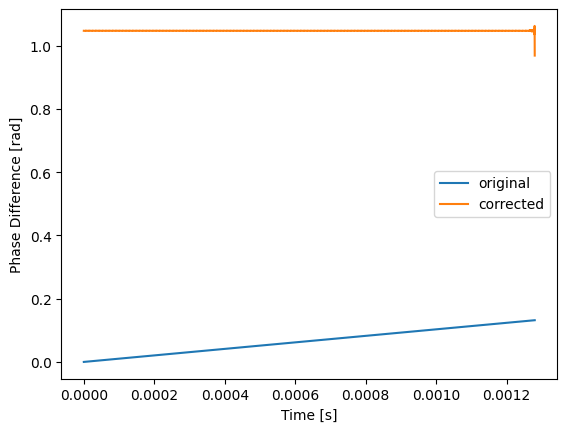

In [132]:
rs_cos = resamp_real * tone_cos - resamp_imag * tone_sin
rs_sin = resamp_real * tone_sin + resamp_imag * tone_cos
rs_dphi = np.arctan2(rs_sin, rs_cos)

plt.figure()
plt.plot(t, dphi, label="original")
plt.plot(t, rs_dphi, label="corrected")
plt.ylabel("Phase Difference [rad]")
plt.xlabel("Time [s]")
plt.legend()
plt.show()

## Real data

In [144]:
d = np.load("../data/data_0403.npz")
data = d["data"][1:, 0]
rs_data = d["rs_data"][1:]
dphi = d["dphi"][1:]
rs_dphi = d["rs_dphi"][1:]
NSAMPLES = data.shape[1]
t = t[:NSAMPLES]
tone_cos = np.cos(omega * t)
tone_sin = -np.sin(omega * t)

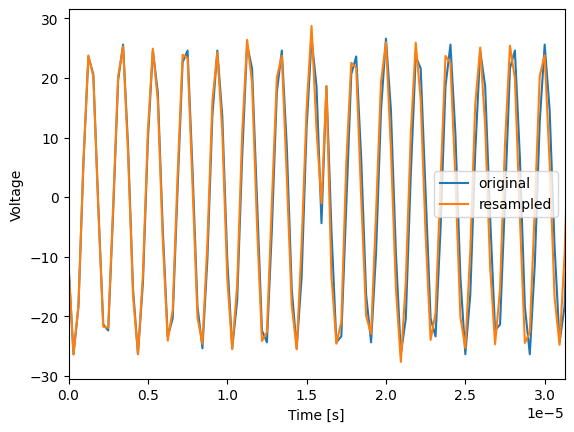

In [145]:
plt.figure()
plt.plot(t, data[0, :, 0], label="original")
plt.plot(t, rs_data[0, :, 0], label="resampled")
plt.ylabel("Voltage")
plt.xlabel("Time [s]")
plt.legend()
plt.xlim(0, t[100])
plt.show()

In [146]:
diff = np.abs(np.diff(dphi, axis=1))
for i, di in enumerate(diff):
    m = di.max()
    if m < 0.1:
        print(i, m)

1 0.07484214541233358
3 0.06832814857405012
7 0.06399752183400809
8 0.06533192818234568
10 0.061187950083205545
14 0.060180005862579655
15 0.05274442481045538
16 0.059192254011183776
20 0.0687053157414712
24 0.06465173243857514
27 0.058875537085763874
28 0.05907117813394791
31 0.05655150901094075
34 0.06063721660289101
35 0.05833850193902146
36 0.06588206415169506
37 0.05485662323246715
45 0.06550888079630557
46 0.05440709970177382
47 0.055656317504751196
50 0.05517524003243923
52 0.05474695878572011


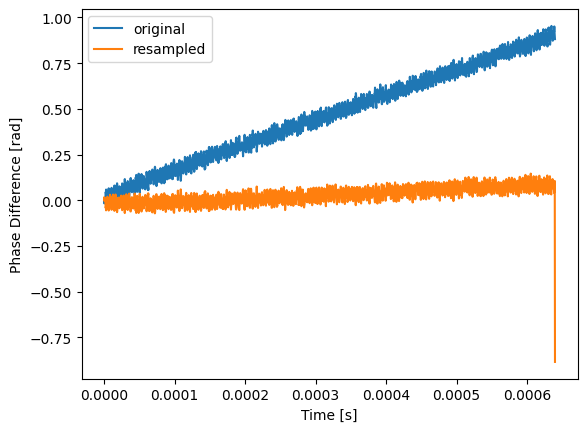

In [155]:
ix = 52
plt.figure()
plt.plot(t, dphi[ix], label="original")
plt.plot(t, rs_dphi[ix]-rs_dphi[ix, 0], label="resampled")
plt.ylabel("Phase Difference [rad]")
plt.xlabel("Time [s]")
plt.legend()
plt.show()